##### Author: Pablo Iañez Picazo
##### Biomedical Data Science lab

In [1]:
# Load all the necessary libraries
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from methods import hsc_spatial_stats as hsc
from methods import seg_utils

In [2]:
# ---------------------- Set up processing parameters ---------------------- #

# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1

cft = 0.6  # ZSCORENORM
norm = "z_score"
folder = "../data/preprocessed"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
]

palette = {
    "young": (0.00392, 0.45098, 0.69803),
    "aged": (0.00784, 0.61960, 0.45098),
    "aged_treated_RhoAi": (0.8, 0.47058, 0.73725),
}

young


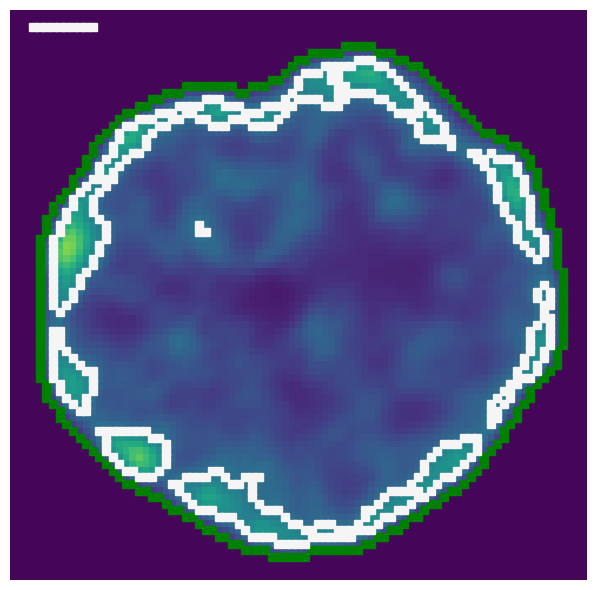

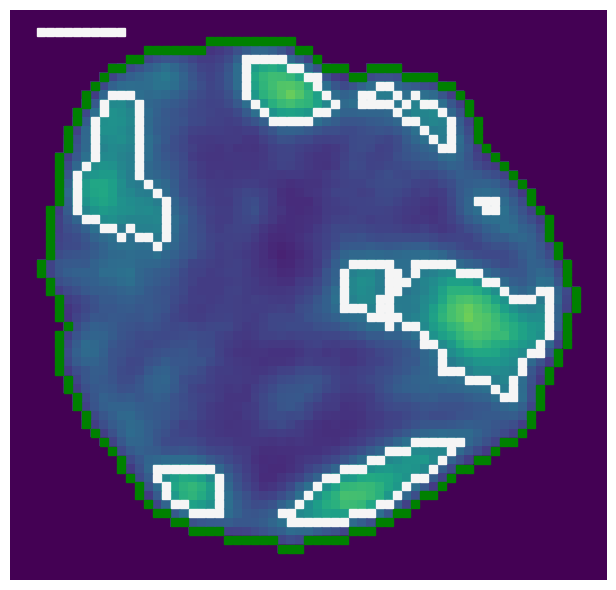

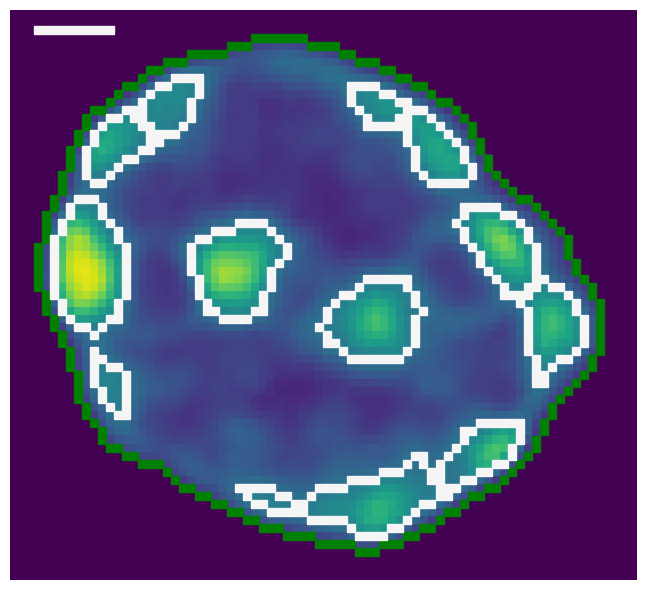

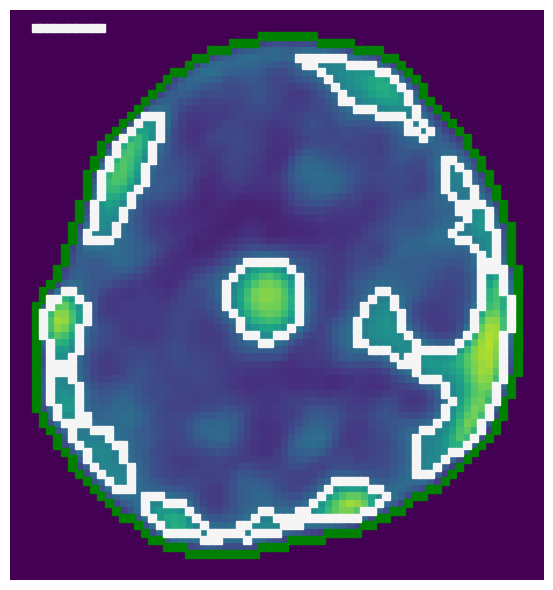

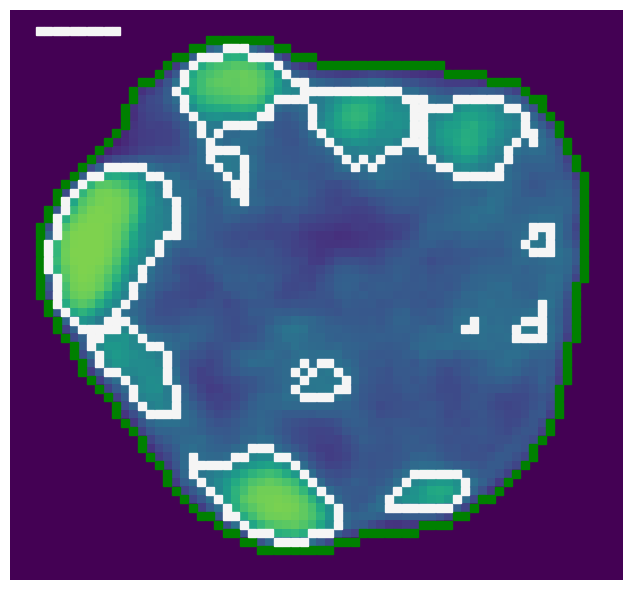

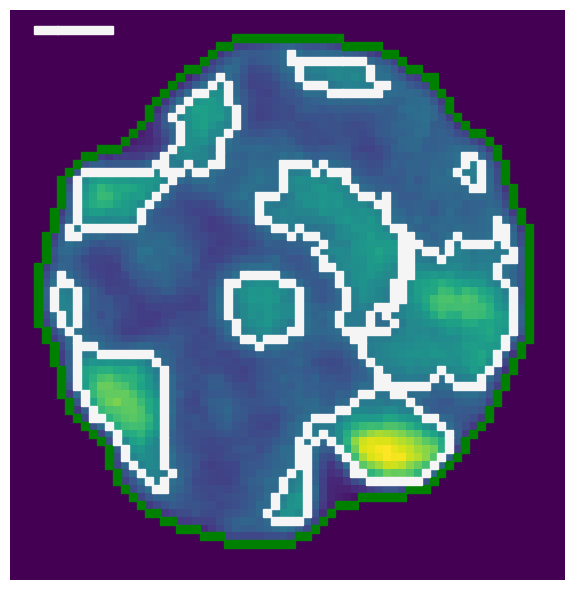

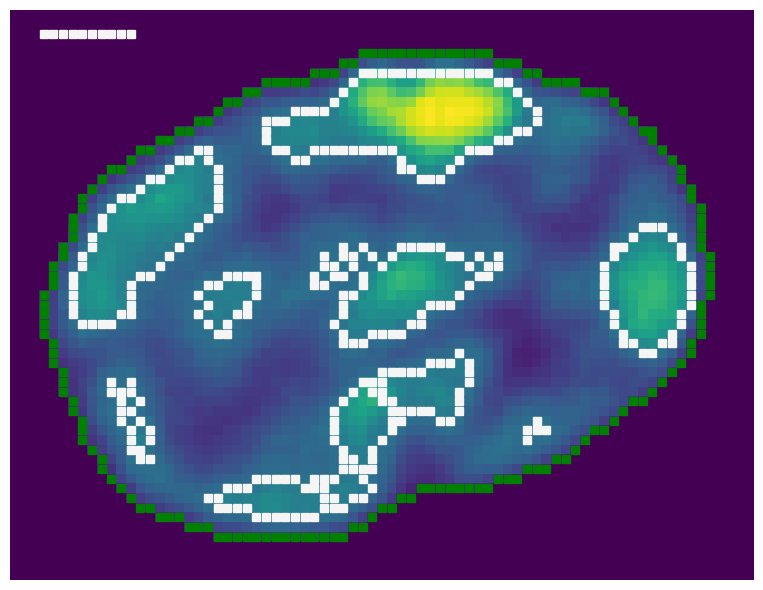

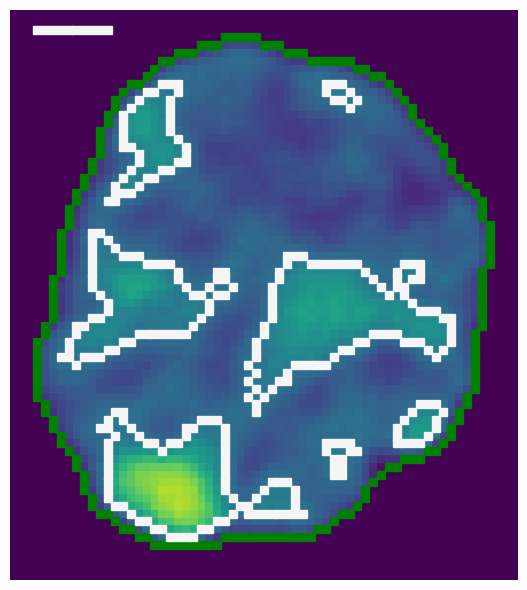

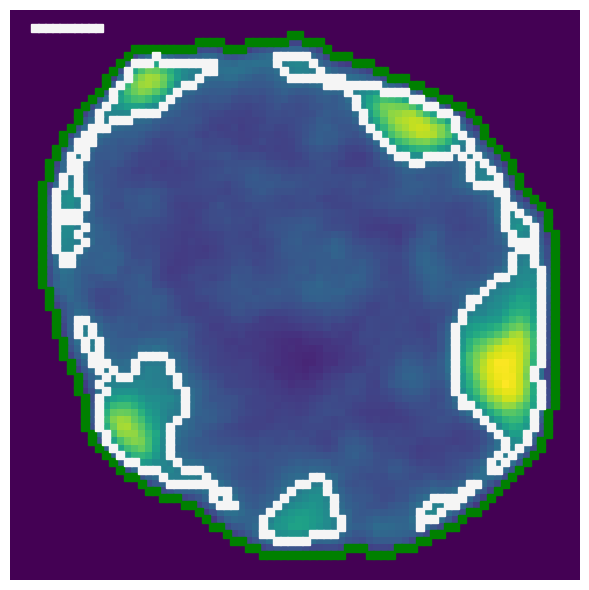

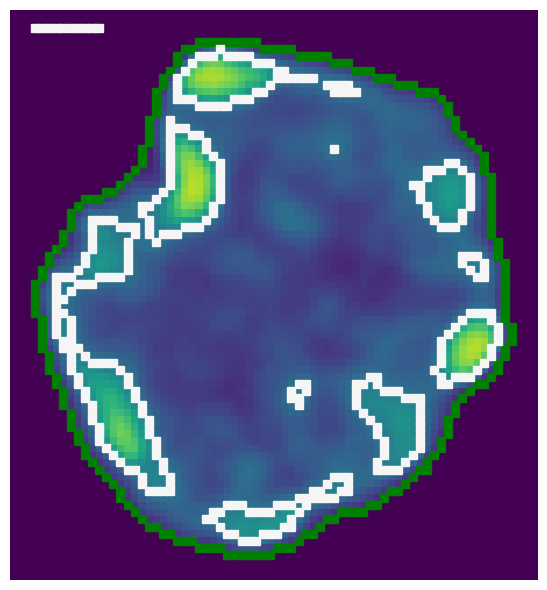

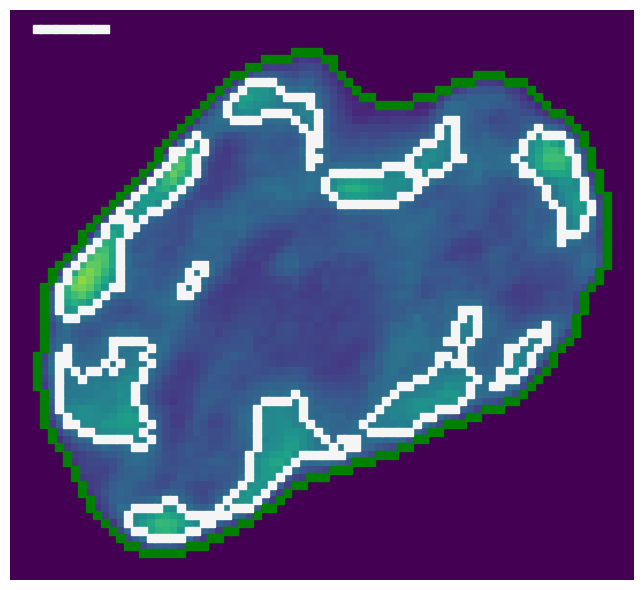

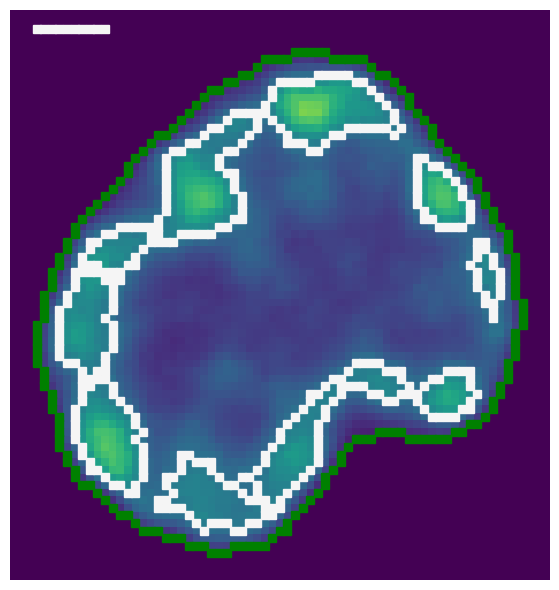

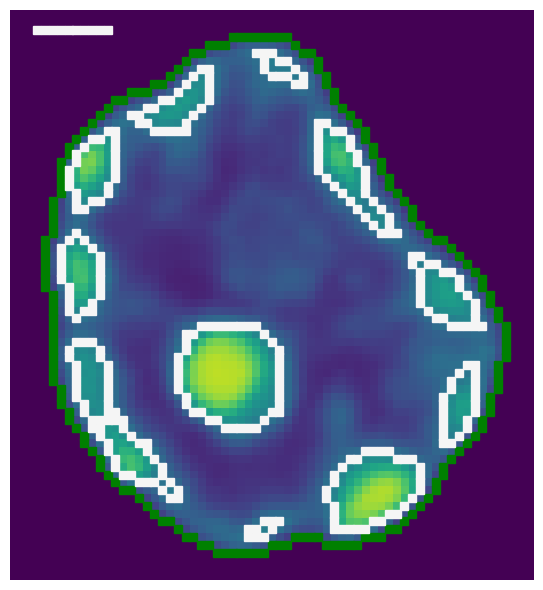

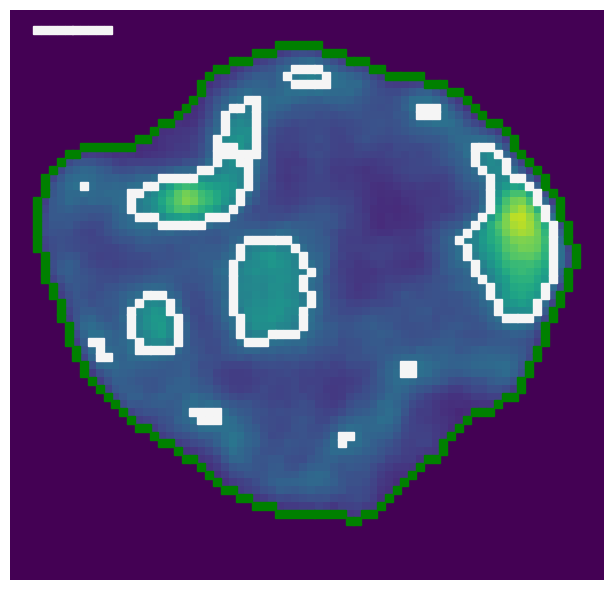

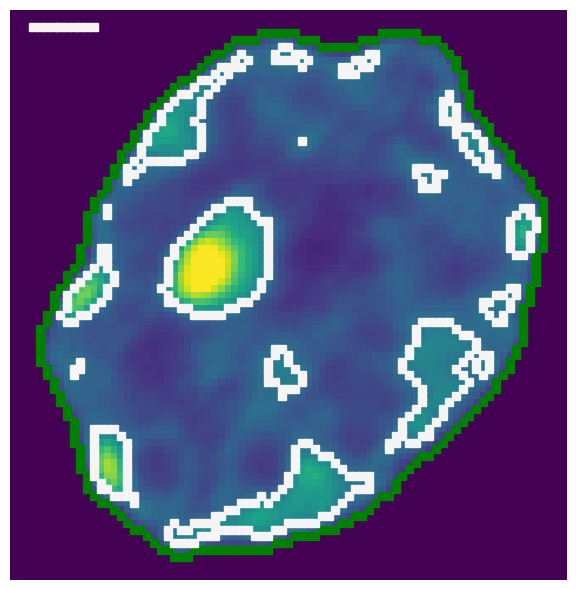

aged


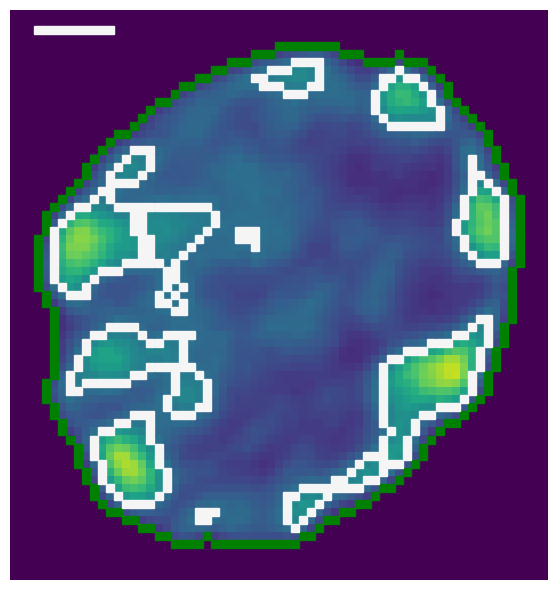

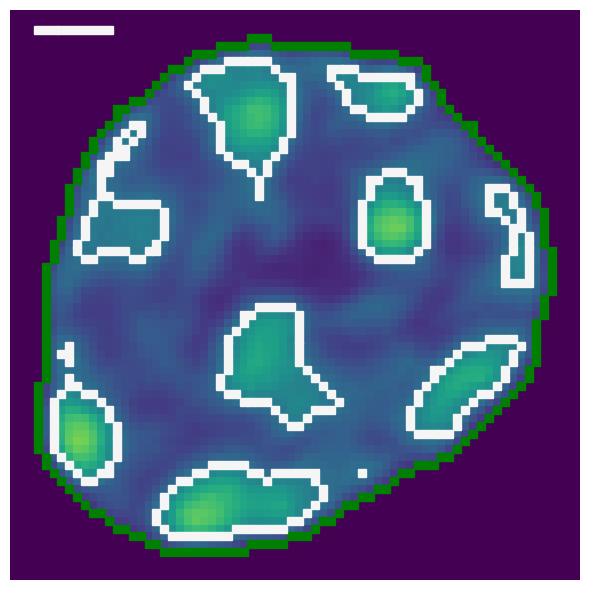

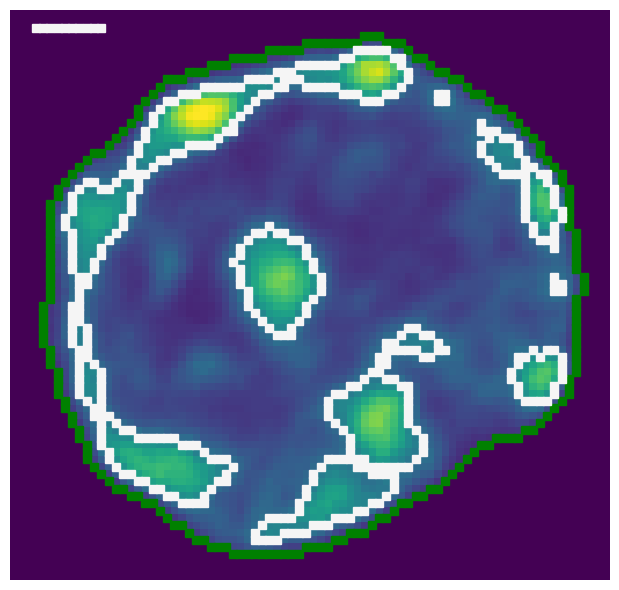

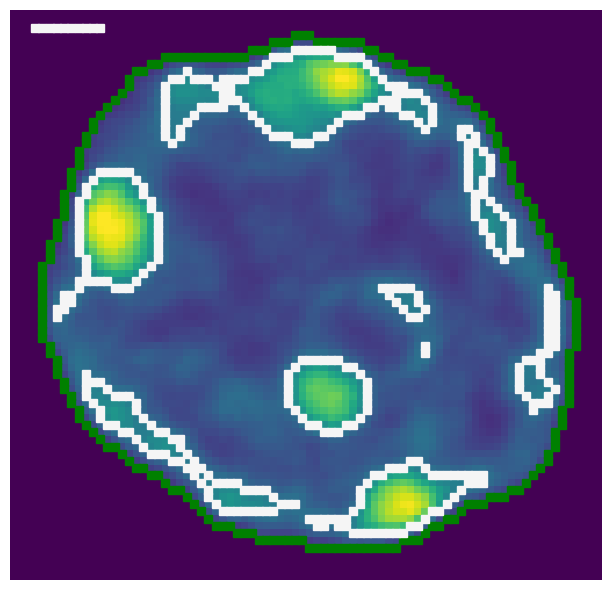

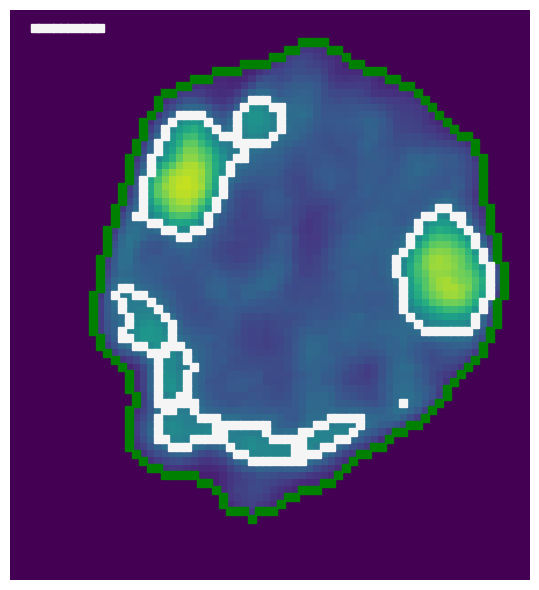

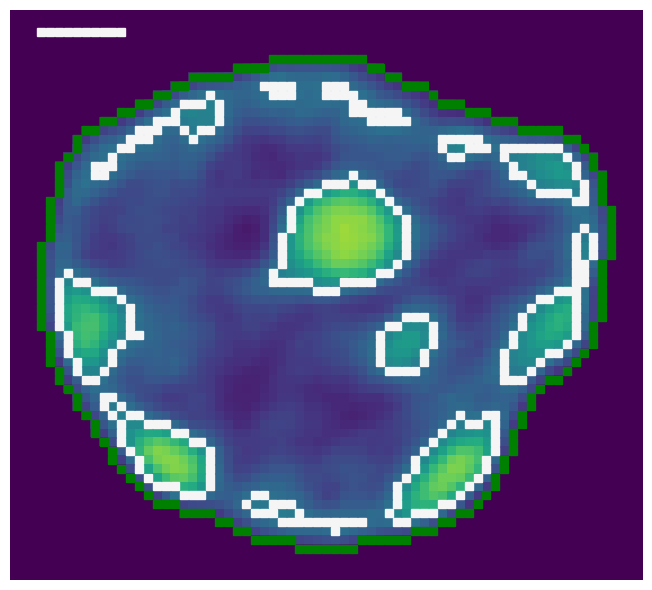

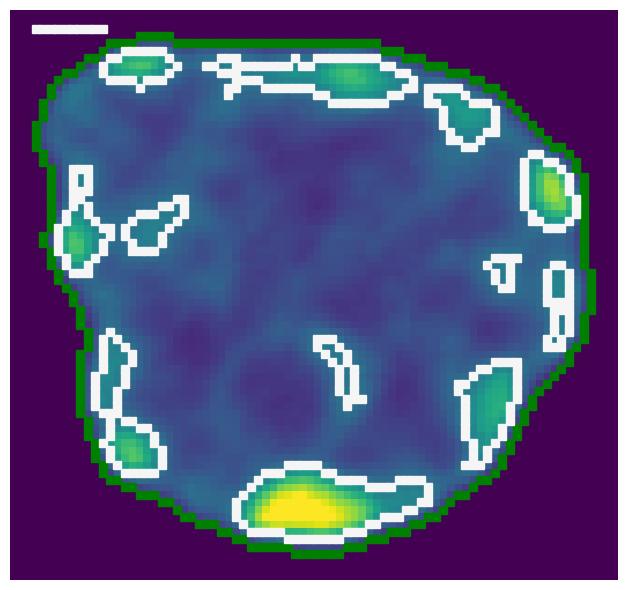

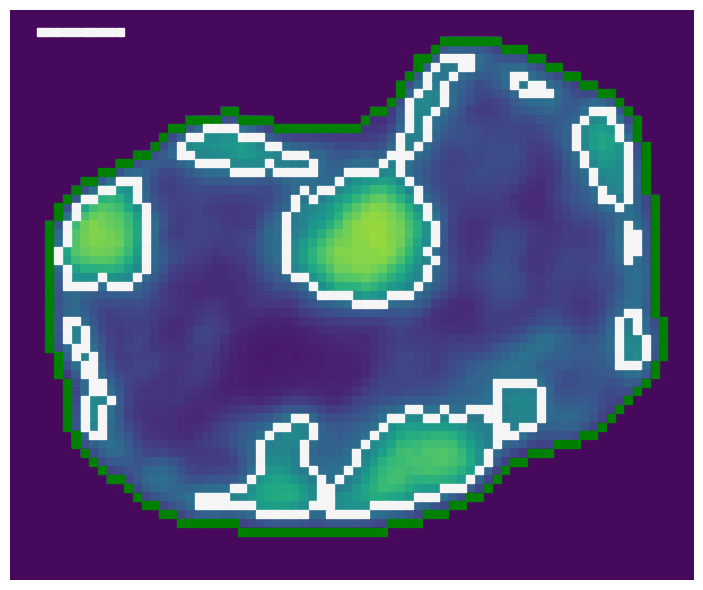

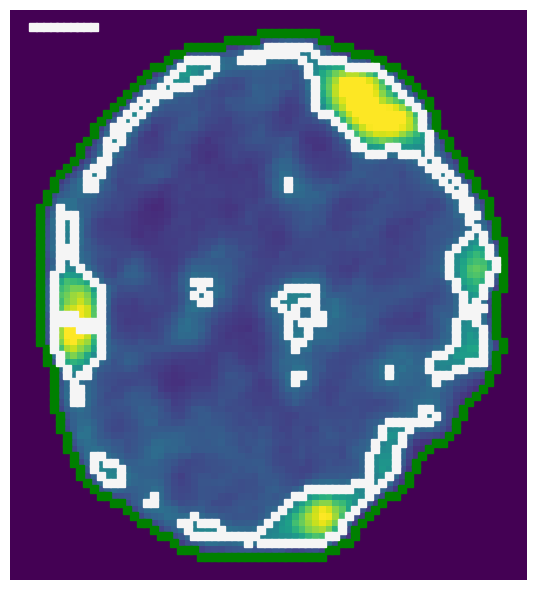

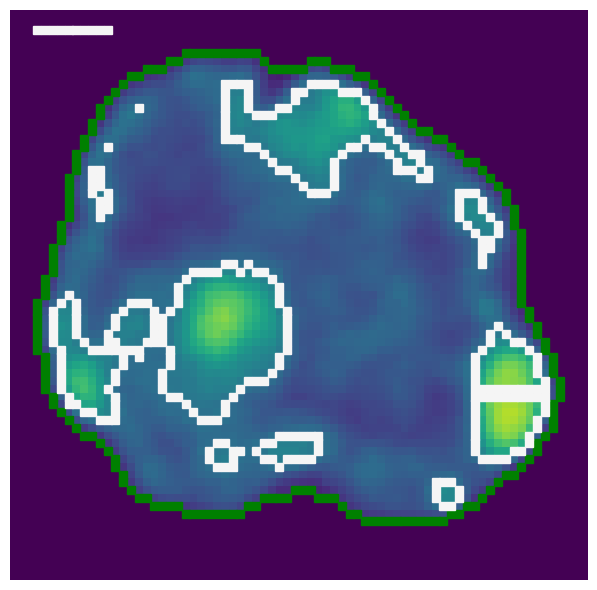

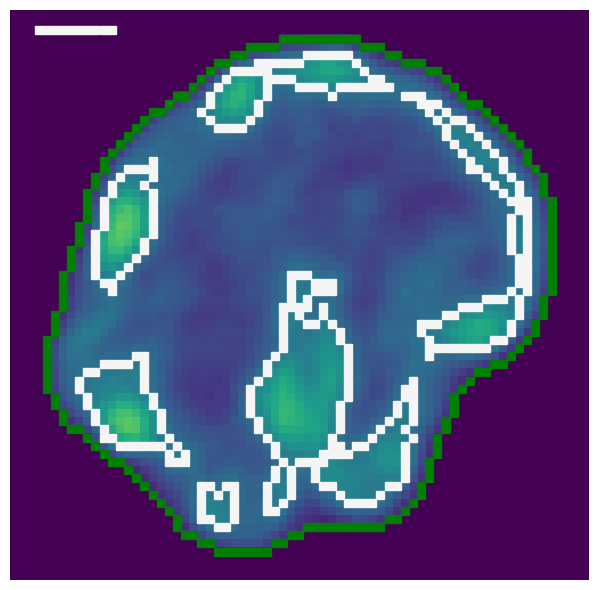

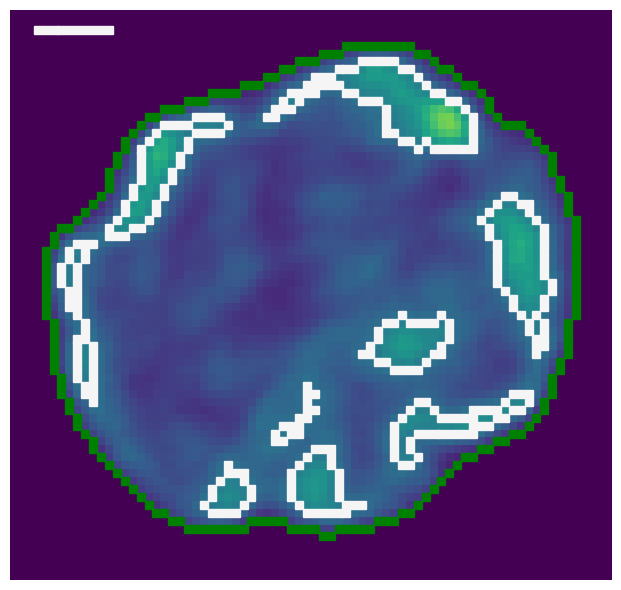

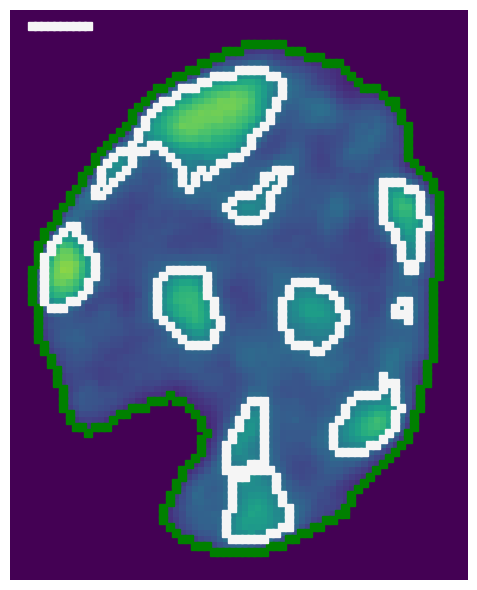

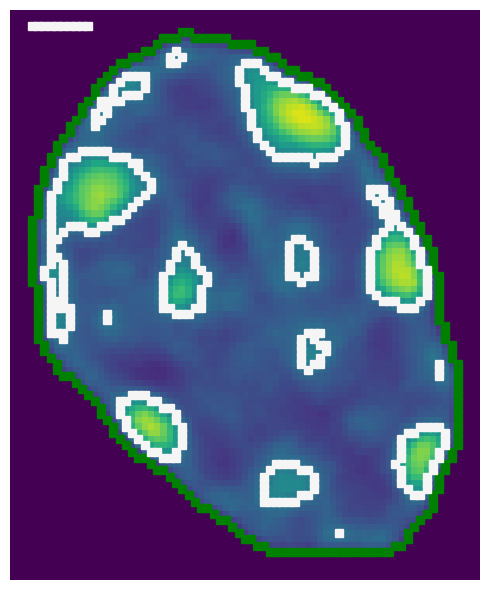

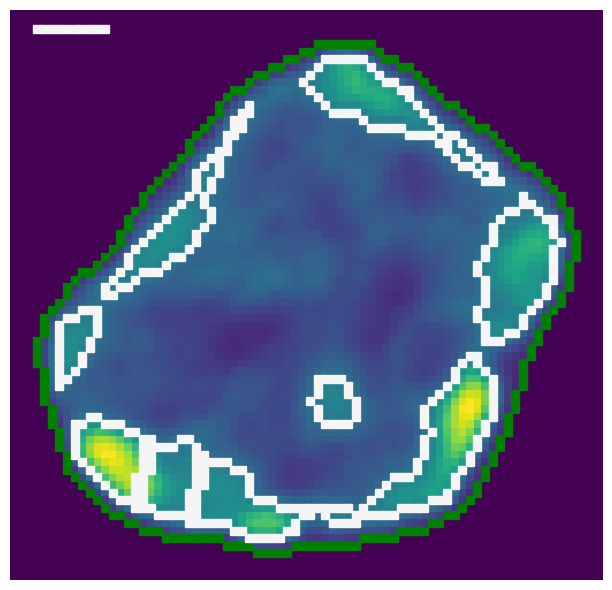

aged_treated_RhoAi


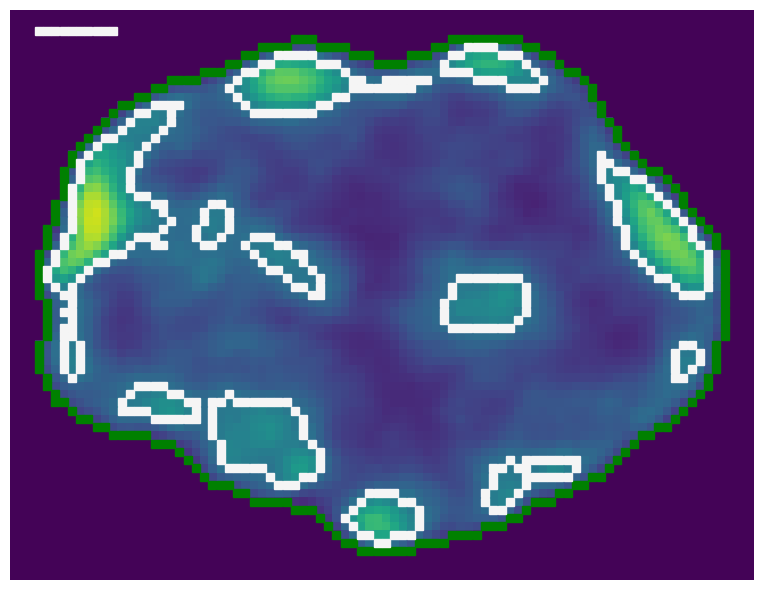

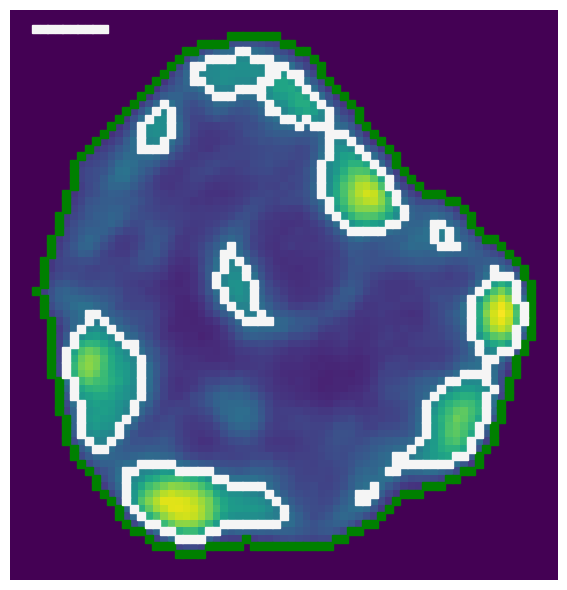

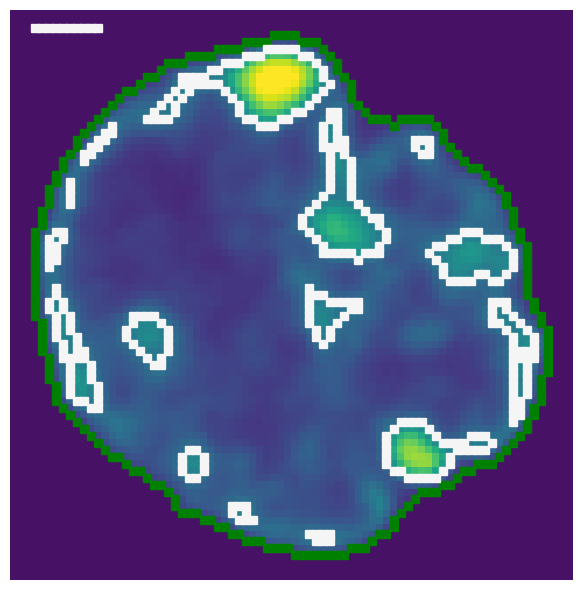

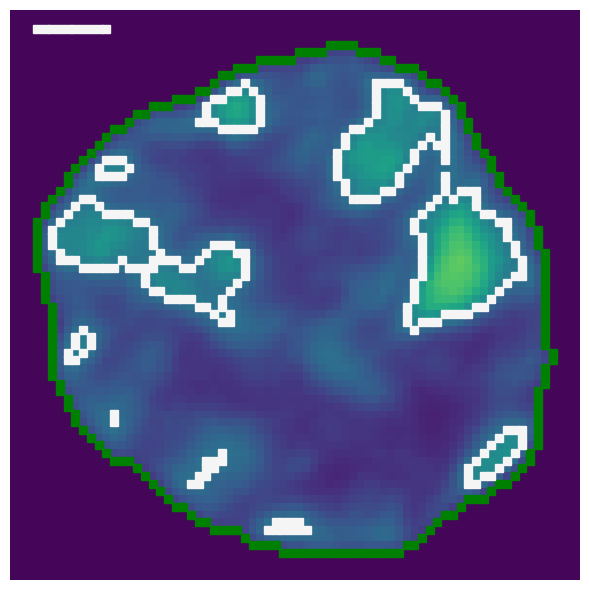

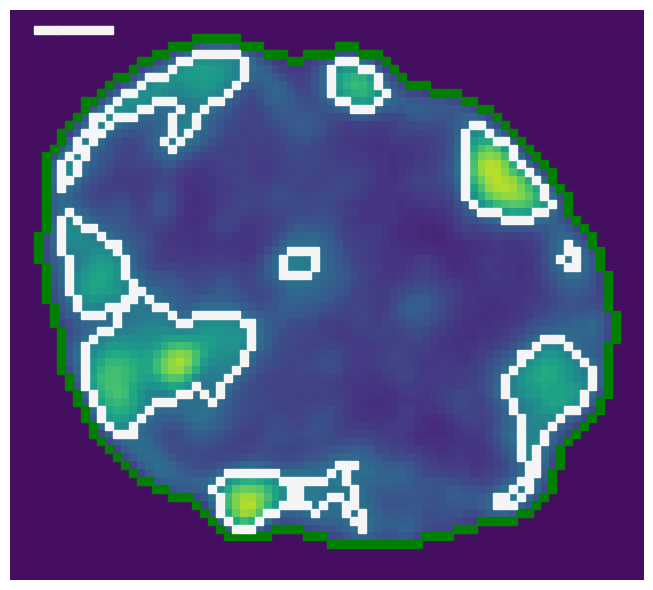

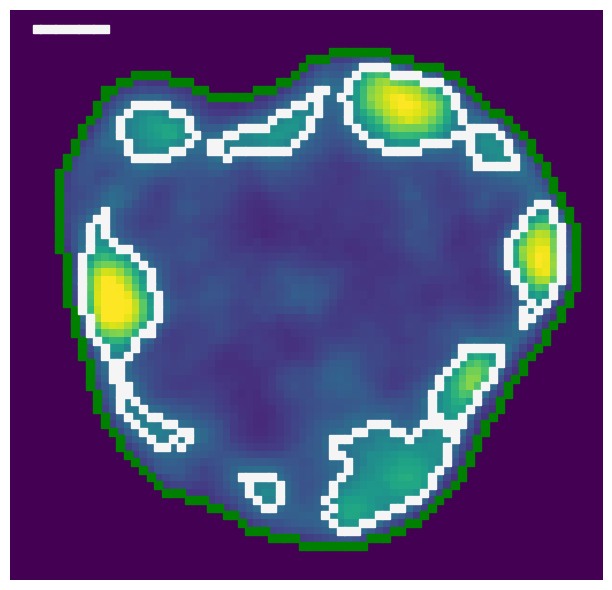

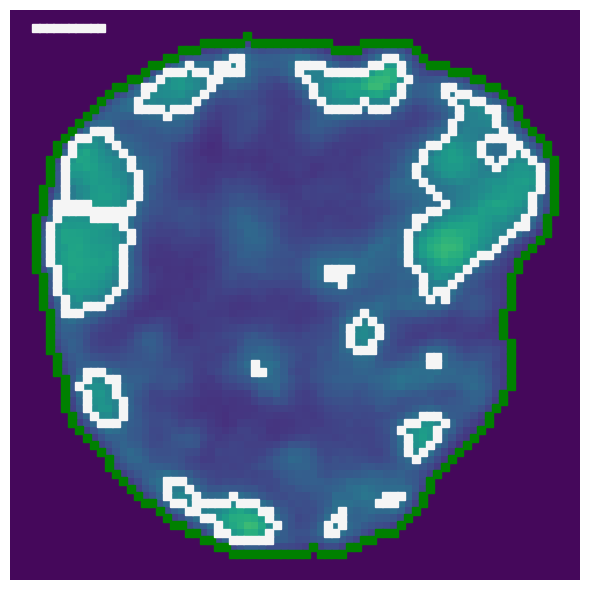

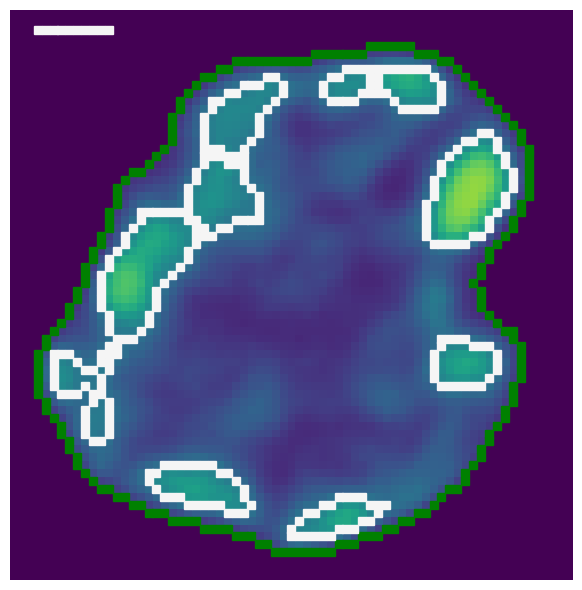

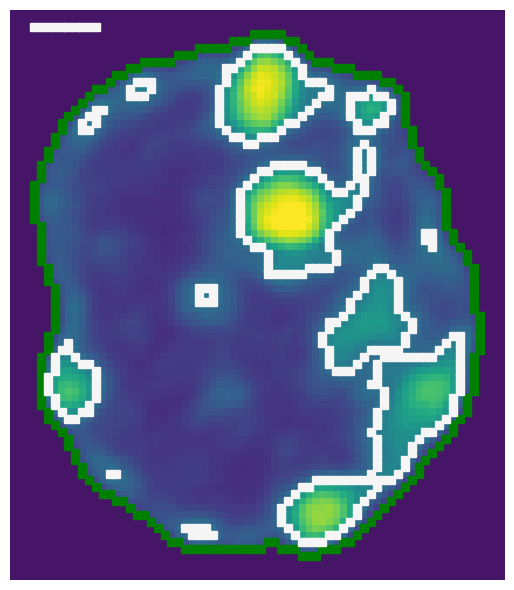

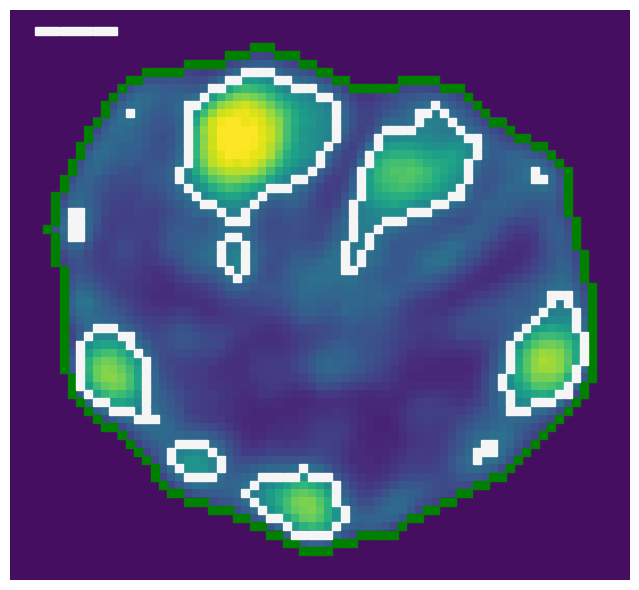

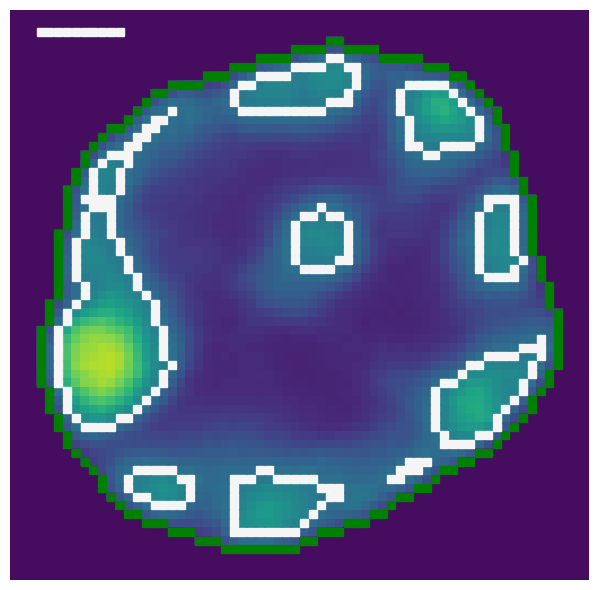

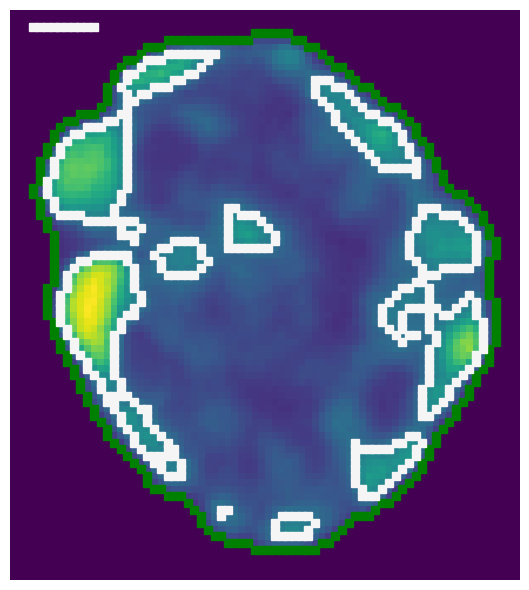

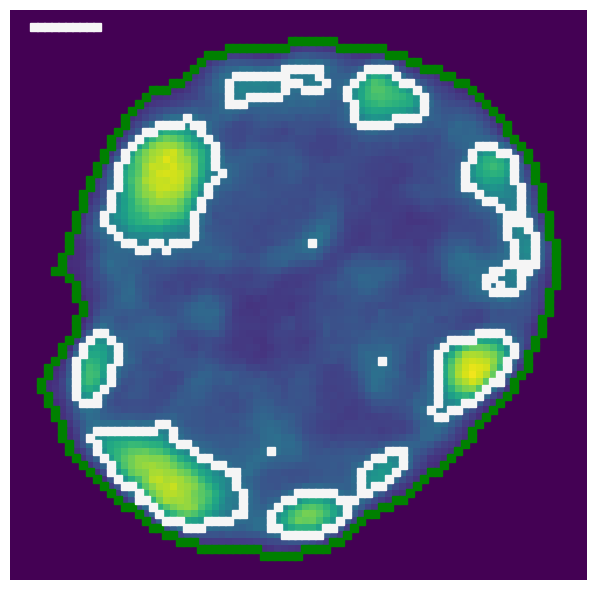

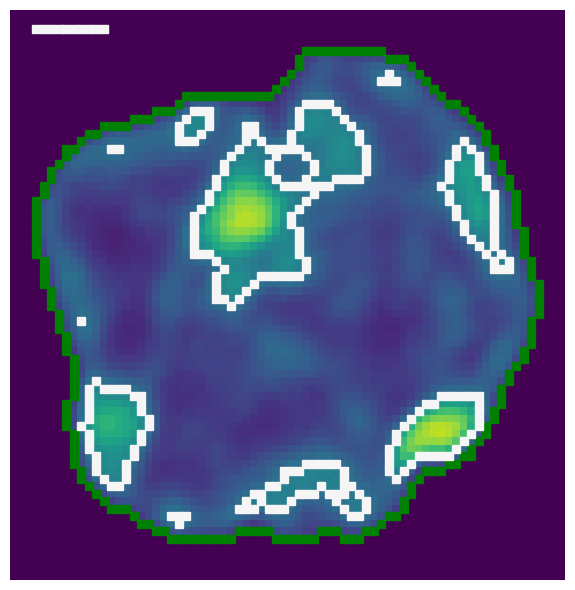

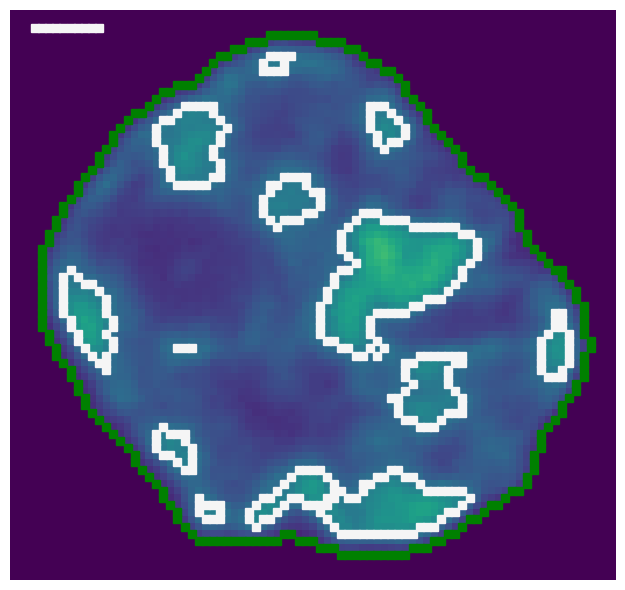

In [3]:
for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob.glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    print(cond)

    for npz in npz_ims[:15]:

        fig, ax = plt.subplots(figsize=(10, 6))

        image = np.load(npz)
        mask = image["nuc_mask"]
        im = image["img"]

        # Rotate the image and convert to XYZ coordenates
        im, mask = hsc.from_zxy_to_xyz([im, mask])

        max_index = np.argmax(mask.sum(0).sum(0))
        im, mask = im[:, :, max_index], mask[:, :, max_index]

        # Segment with Watershed algorithm
        DIRs_mask = seg_utils.segment_condensates(
            im, mask, cluster_thresh=cft, mode="absolute"
        )
        # df_DIRs = hsc.get_DIRs_metrics_2D(DIRs_mask, im, res=0.1)
        # DIRs_mask, df_DIRs = hsc.filter_DIRs(
        #    DIRs_mask, df_DIRs, query="include == False or area < 0.2"
        # )

        plot = ax.imshow(im, vmin=-2, vmax=5, cmap="viridis")
        ax = seg_utils.plot_mask_contour(mask, ax, color="green")
        ax = seg_utils.plot_mask_contour(DIRs_mask, ax, color="whitesmoke")

        # Draw the resolution marker line depicting 1 micrometer
        for i, num in enumerate(range(3, 13)):
            ax.plot(num, 2, linestyle="None", marker="s", color="whitesmoke")

        # cbar = plt.colorbar(plot, ax=ax, aspect=5)
        # cbar.ax.tick_params(labelsize=40)

        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

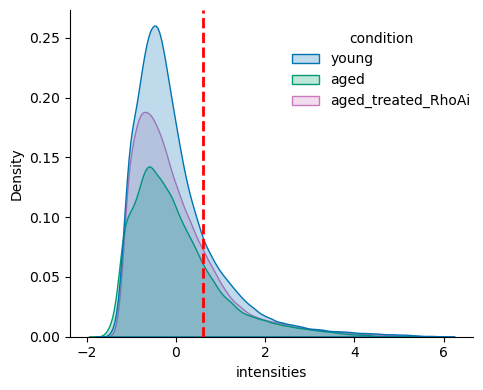

In [4]:
data = []
image_id = 1
for cond in conditions:
    npz_ims = glob.glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    for npz in npz_ims[:2]:
        image = np.load(npz)
        nuc_mask = image["nuc_mask"]
        im = image["img"]
        roi = im[nuc_mask.astype(bool)]
        data.append((roi.ravel(), cond, image_id))
        image_id += 1

# Combine all data
intensities = np.concatenate([d[0] for d in data])
conds = np.concatenate([[d[1]] * len(d[0]) for d in data])
images = np.concatenate([[d[2]] * len(d[0]) for d in data])

hist_df = pd.DataFrame(
    {"intensities": intensities, "condition": conds, "image": images}
)

plot = sns.displot(
    hist_df,
    x="intensities",
    hue="condition",
    kind="kde",
    fill=True,
    palette=palette,
    height=4,  # Height in inches
    aspect=1.25,
)
plot._legend.set_bbox_to_anchor((0.7, 0.8))  # (x, y) position inside plot

plt.axvline(x=0.6, color="red", linestyle="--", linewidth=2)
plt.show()